### 1. Load and Preprocess the Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

# Load datasets
train_df = pd.read_csv('/kaggle/input/uit-visfd/Train.csv')
test_df = pd.read_csv('/kaggle/input/uit-visfd/Test.csv')
dev_df = pd.read_csv('/kaggle/input/uit-visfd/Dev.csv')

2025-05-02 16:28:10.637825: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-02 16:28:10.637980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-02 16:28:10.795710: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_df.head()

,index,comment,n_star,date_time,label
0,0,Mới mua máy này Tại thegioididong thốt nốt cảm...,5,2 tuần trước,{CAMERA#Positive};{FEATURES#Positive};{BATTERY...
1,1,Pin kém còn lại miễn chê mua 8/3/2019 tình trạ...,5,14/09/2019,{BATTERY#Negative};{GENERAL#Positive};{OTHERS};
2,2,Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,3,17/08/2020,{FEATURES#Negative};
3,3,"Mọi người cập nhật phần mềm lại , nó sẽ bớt tố...",3,29/02/2020,{FEATURES#Negative};{BATTERY#Neutral};{GENERAL...
4,4,"Mới mua Sài được 1 tháng thấy pin rất trâu, Sà...",5,4/6/2020,{BATTERY#Positive};{PERFORMANCE#Positive};{SER...


In [3]:
!pip install -q pyvi underthesea num2words

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [4]:
import re
import unicodedata
from underthesea import word_tokenize
import string
from pyvi import ViTokenizer
from num2words import num2words

#Lowercase
def lowercase(text):
    return text.lower()

#Remove các ký tự kéo dài: vd: đẹppppppp
def remove_elongated_chars(text):
    replacements = {
       'a' : 'àáảãạăằắẳẵặâầấẩẫậ' ,
       'e' : 'èéẻẽẹêềếểễệ' ,
       'i' : 'ìíỉĩị' ,
       'o' : 'òóỏõọôồốổỗộơờớởỡợ' ,
       'u' : 'ùúủũụưừứửữự' ,
       'y' : 'ỳýỷỹỵ' ,
       'd' : 'đ' ,
       'A' : 'ÀÁẢÃẠĂẰẮẲẴẶÂẦẤẨẪẬ' ,
       'E' : 'ÈÉẺẼẸÊỀẾỂỄỆ' ,
       'I' : 'ÌÍỈĨỊ' ,
       'O' : 'ÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢ' ,
       'U' : 'ÙÚỦŨỤƯỪỨỬỮỰ' ,
       'Y' : 'ỲÝỶỸỴ' ,
       'D' : 'Đ' 
    }
    
    for char, replacements_str in replacements.items():
        pattern = rf"({char})\1+"
        text = re.sub(pattern, ' ' , text)
    pattern = rf"(\w)\1+"
    text = re.sub(pattern, r'\1', text)
    return text

#Sử dụng thư viện unicodedata để chuyển đổi các ký tự Unicode 
#tương đương thành dạng chuẩn. Ví dụ: "Hoà" thành "Hòa".
def normalize_unicode(text):
    return unicodedata.normalize("NFC", text)

#Xử lý Emoji
#Quy các icon về 2 loại emoj: Tích cực hoặc tiêu cực
def process_emojis(text):
    emojis_list = {
        "👹": "negative", "👻": "positive", "💃": "positive",'🤙': 'positive ', '👍': 'positive ',
        "💄": "positive", "💎": "positive", "💩": "positive","😕": "negative", "😱": "negative", "😸": "positive",
        "😾": "negative", "🚫": "negative",  "🤬": "negative","🧚": "positive", "🧡": "positive",'🐶':'positive ',
        '👎': 'negative ', '😣': 'negative ','✨': 'positive ', '❣': 'positive ','☀': 'positive ',
        '♥': 'positive ', '🤩': 'positive ', 'like': 'positive ', ':))': 'positive ', ':)': 'positive ',
        'he he': 'positive ','hehe': 'positive ','hihi': 'positive ', 'haha': 'positive ', 'hjhj': 'positive ',
        ' lol ': 'negative ',' cc ': 'negative ', 'huhu': 'negative ', '><': u'positive ',
        '💌': 'positive ', '🥰': 'positive ', '🙆' : 'positive ', '😅' : 'negative ',
        '🤒' : 'negative ', '🤨' : 'negative ', '🤦' : 'negative ', '😬' :'negative ',
        '🔋' : 'positive ', '💔' : 'negative ', '🤮' : 'negative ', '✋' : 'positive ',
        '🤣': 'positive ', '🖤': 'positive ', '🤤': 'positive ', ':(': 'negative ', '😢': 'negative ',
        '❤': 'positive ', '😍': 'positive ', '😘': 'positive ', '😪': 'negative ', '😊': 'positive ',
        '?': ' ? ', '😁': 'positive ', '💖': 'positive ', '😟': 'negative ', '😭': 'negative ',
        '💯': 'positive ', '💗': 'positive ', '♡': 'positive ', '💜': 'positive ', '🤗': 'positive ',
        '^^': 'positive ', '😨': 'negative ', '☺': 'positive ', '💋': 'positive ', '👌': 'positive ',
        '😖': 'negative ', '😀': 'positive ', ':((': 'negative ', '😡': 'negative ', '😠': 'negative ',
        '😒': 'negative ', '🙂': 'positive ', '😏': 'negative ', '😝': 'positive ', '😄': 'positive ',
        '😙': 'positive ', '😤': 'negative ', '😎': 'positive ', '😆': 'positive ', '💚': 'positive ',
        '✌': 'positive ', '💕': 'positive ', '😞': 'negative ', '😓': 'negative ', '️🆗️': 'positive ',
        '😉': 'positive ', '😂': 'positive ', ':v': 'positive ', '=))': 'positive ', '😋': 'positive ',
        '💓': 'positive ', '😐': 'negative ', ':3': 'positive ', '😫': 'negative ', '😥': 'negative ',
        '😃': 'positive ', '😬': ' 😬 ', '😌': ' 😌 ', '💛': 'positive ', '🤝': 'positive ', '🎈': 'positive ',
        '😗': 'positive ', '🤔': 'negative ', '😑': 'negative ', '🔥': 'negative ', '🙏': 'negative ',
        '🆗': 'positive ', '😻': 'positive ', '💙': 'positive ', '💟': 'positive ',
        '😚': 'positive ', '❌': 'negative ', '👏': 'positive ', ';)': 'positive ', '<3': 'positive ',
        '🌝': 'positive ',  '🌷': 'positive ', '🌸': 'positive ', '🌺': 'positive ',
        '🌼': 'positive ', '🍓': 'positive ', '🐅': 'positive ', '🐾': 'positive ', '👉': 'positive ',
        '💐': 'positive ', '💞': 'positive ', '💥': 'positive ', '💪': 'positive ',
        '💰': 'positive ',  '😇': 'positive ', '😛': 'positive ', '😜': 'positive ',
        '🙃': 'negative ', '🤑': 'positive ', '🤪': 'positive ','☹': 'negative ',  '💀': 'negative ',
        '😔': 'negative ', '😧': 'negative ', '😩': 'negative ', '😰': 'negative ', '😳': 'negative ',
        '😵': 'negative ', '😶': 'negative ', '🙁': 'negative ', '🎉': 'positive '}
    for emoji, label in emojis_list.items():
        text = text.replace(emoji, f'EMO{label.upper()}' )
        
    text = ' ' .join(text.split())
    return text

#Chuẩn hóa từ vùng (Sentiment Word)
#Tạo từ điển ánh xạ các từ vựng cần chuẩn hóa sang dạng chuẩn. 
#Ví dụ: {"okie": "ok", "okey": "ok", "authentic": "chuẩn chính hãng"}.
#Sử dụng từ điển này để thay thế các từ vựng trong văn bản.

def normalize_sentiment_words(text):
    sentiment_word_map = {
        'ô kêi': ' ok ', 'okie': ' ok ', ' o kê ': ' ok ',
        'okey': ' ok ', 'ôkê': ' ok ', 'oki': ' ok ', ' oke ':  ' ok ',' okay':' ok ','okê':' ok ',
        ' tks ': u' cám ơn ', 'thks': u' cám ơn ', 'thanks': u' cám ơn ', 'ths': u' cám ơn ', 'thank': u' cám ơn ',
        '⭐': 'star ', '*': 'star ', '🌟': 'star ',
        'kg ': u' không ','not': u' không ', u' kg ': u' không ', '"k ': u' không ',' kh ':u' không ','kô':u' không ','hok':u' không ',' kp ': u' không phải ',u' kô ': u' không ', '"ko ': u' không ', u' ko ': u' không ', u' k ': u' không ', 'khong': u' không ', u' hok ': u' không ',
        'cute': u' dễ thương ', ' vs ': u' với ', 'wa': ' quá ', 'wá': u' quá', 'j': u' gì ', '“': ' ',
        ' sz ': u' cỡ ', 'size': u' cỡ ', u' đx ': u' được ', 'dk': u' được ', 'dc': u' được ', 'đk': u' được ',
        'đc': u' được ','authentic': u' chuẩn chính hãng ',u' aut ': u' chuẩn chính hãng ', u' auth ': u' chuẩn chính hãng ', 'store': u' cửa hàng ',
        'shop': u' cửa hàng ', 'sp': u' sản phẩm ', 'gud': u' tốt ','god': u' tốt ','wel done':' tốt ', 'good': u' tốt ', 'gút': u' tốt ',
        'sấu': u' xấu ','gut': u' tốt ', u' tot ': u' tốt ', u' nice ': u' tốt ', 'perfect': 'rất tốt', 'bt': u' bình thường ',
        'time': u' thời gian ', 'qá': u' quá ', u' ship ': u' giao hàng ', u' m ': u' mình ', u' mik ': u' mình ',
        'ể': 'ể', 'product': 'sản phẩm', 'quality': 'chất lượng','chat':' chất ', 'excelent': 'hoàn hảo', 'bad': 'tệ','fresh': ' tươi ','sad': ' tệ ',
        'date': u' hạn sử dụng ', 'hsd': u' hạn sử dụng ','quickly': u' nhanh ', 'quick': u' nhanh ','fast': u' nhanh ','delivery': u' giao hàng ',u' síp ': u' giao hàng ',
        'beautiful': u' đẹp tuyệt vời ', u' tl ': u' trả lời ', u' r ': u' rồi ', u' shopE ': u' cửa hàng ',u' order ': u' đặt hàng ',
        'chất lg': u' chất lượng ',u' sd ': u' sử dụng ',u' dt ': u' điện thoại ',u' nt ': u' nhắn tin ',u' tl ': u' trả lời ',u' sài ': u' xài ',u'bjo':u' bao giờ ',
        'thick': u' thích ', 'thik': u' thích ', u' sop ': u' cửa hàng ', u' shop ': u' cửa hàng ', 
        ' fb ': ' facebook ', ' face ': ' facebook ', ' very ': u' rất ',u'quả ng ':u' quảng  ',
        'dep': u' đẹp ',u' xau ': u' xấu ','delicious': u' ngon ', u'hàg': u' hàng ', u'qủa': u' quả ',
        'iu': u' yêu ','fake': u' giả mạo ', 'trl': 'trả lời',
        ' por ': u' tệ ',' poor ': u' tệ ', 'ib':u' nhắn tin ', 'rep':u' trả lời ',u'fback':' feedback ','fedback':' feedback '
    }
    for word, replacement in sentiment_word_map.items():
        text = text.replace(word, replacement)
    return text

#Chuẩn hóa số sao đánh giá/điểm số
def normalize_stars(text):
    stars_map = {
        '5star': 'positive ','5 sao': 'positive ','5sao': 'positive ', 'starstarstarstarstar': 'positive ',
        '4star': 'positive ','4 sao': 'positive ','4sao': 'positive ', 'starstarstarstar': 'positive ',
        '3star': 'negative ','3 sao': 'negative ','3sao': 'negative ', 'starstarstar': 'negative ',
        '2star': 'negative ','2 sao': 'negative ','2sao': 'negative ', 'starstar': 'negative ',
        '1star': 'negative ','1 sao': 'negative ','1sao': 'negative ', 'star': 'negative ',
        '0star': 'negative ','0 sao': 'negative ','0sao': 'negative ',
        '10 điểm' : 'positive ', ' 10đ' : 'positive ', 'mười điểm' : 'positive ', 'mừi điểm' : 'positive ',
        '9 điểm' : 'positive ', ' 9đ' : 'positive ', 'chín điểm' : 'positive ',
        '8 điểm' : 'positive ', ' 8đ' : 'positive ', 'tám điểm' : 'positive ',
        '7 điểm' : 'positive ', ' 7đ' : 'positive ', 'bảy điểm' : 'positive ',
        '6 điểm' : 'negative ', ' 6đ' : 'negative ', 'sáu điểm' : 'negative ',
        '5 điểm' : 'negative ', ' 5đ' : 'negative ', 'năm điểm' : 'negative ',
        '4 điểm' : 'negative ', ' 4đ' : 'negative ', 'bốn điểm' : 'negative ',
        '3 điểm' : 'negative ', ' 3đ' : 'negative ', 'ba điểm' : 'negative ',
        '2 điểm' : 'negative ', ' 2đ' : 'negative ', 'hai điểm' : 'negative ',
        '1 điểm' : 'negative ', ' 1đ' : 'negative ', 'một điểm' : 'negative ',
        '0 điểm' : 'negative ', ' 0đ' : 'negative ', 'không điểm' : 'negative ',
        }
    for star, label in stars_map.items():
        text = text.replace(star, f'SCORE{label.upper()}' )
        
    text = ' ' .join(text.split())
    return text

def remove_punctuation(text):
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(translator)
    return text

def remove_diacritics(text):
    text = unicodedata.normalize('NFD', text)
    text = ''.join(c for c in text if not unicodedata.combining(c))
    return text

def load_sentiment_lexicon(file_path):
    #Xử lý phủ định
    not_words = {"không", 'không_hề' , "chẳng", "chưa", "không_phải", "chả", "mất", 
                 "thiếu", "vô", "đếch", "đéo", "kém", "nỏ", "not",
                 "bớt", "không_bao_giờ",
                }
    # Tạo tập hợp chứa các từ tích cực
    positive_words = {
        "ưng_ý", "ưng", "kỹ", "được", "ô_kê", "ok", "mịn", "ổn", "xinh", "chúc_mừng",
        "hạnh_phúc", "sang", "oách", "khen", "ổn_định", "cảm_ơn", "cám_ơn", "chuẩn",
        "hoàn_thiện", "chắc_chắn", "sạch_sẽ", "hài_lòng", "chất_lượng", "hấp_dẫn",
        "vui_vẻ", "nguyên_chất", "thuận_lợi", "có_lợi", "tích_cực", "khuyến_khích",
        "tốt_hơn", "vị_tha", "sắc", "bén", "thích_hợp", "quý_báu", "sâu_sắc",
        "thịnh_vượng", "xinh_đẹp", "rực_rỡ", "trong_sáng", "chấp_nhận_được", "khéo_léo",
        "nghệ_thuật", "yên_tâm", "uyển_chuyển", "sôi_động", "nhân_đạo", "thân_mật",
        "thoải_mái", "đặc_biệt", "toàn_diện", "hòa_đồng", "hài_hòa", "thuận_tiện",
        "lịch_sự", "may_mắn", "may", "đoan_trang", "phấn_chấn", "sành_điệu", "sáng_suốt",
        "kín_đáo", "mát_mẻ", "lấp_lánh", "danh_dự", "dễ_dàng", "say_mê", "nhiệt_tình",
        "đạo_đức", "trung_thực", "trung_thành", "chung_thủy", "ngon", "chu_đáo", "ngăn_nắp",
        "lành_mạnh", "hợp_vệ_sinh", "khôn", "khen_ngợi", "quý_giá", "kháng_khuẩn", "êm_tai",
        "tinh_túy", "du_dương", "bổ_ích", "hồng_hào", "khỏe_khoắn", "khỏe_mạnh", "khỏe",
        "mạnh", "săn_chắc", "sung_sức", "mạnh_khỏe", "trẻ_trung", "đùa", "đề_cao", "quản_lý",
        "cánh_tay_phải", "nhận_dạng_được", "hoàn_hảo", "trọn_vẹn", "lý_tưởng", "dễ_an_ủi",
        "đẹp", "duyên_dáng", "tuyệt_vời", "đáng_ngưỡng_mộ", "thú_vị", "ngọt_ngào", "lạc_quan",
        "sinh_lợi", "chính_đáng", "khiêm_tốn", "minh_mẫn", "uy_tín", "vinh_dự", "thẳng_thắn",
        "bảo_đảm", "màu_mỡ", "dễ_chịu", "tươi", "cẩn_thận", "đúng", "hiệu_quả", "cute",
        "dễ_thương", "phê", "xịn", "sịn", "phê", "vui_tính", "chính_hãng", "thực_sự",
        "vinh_quang", "thánh_thiện", "vui_tươi", "gợi_cảm", "cân_đối", "chân_thành",
        "thành_thạo", "tinh_tế", "kiên_cố", "thân_thiện", "thích", "tỏa_sáng", "ngưỡng_mộ",
        "phù_hợp", "hy_vọng", "tốt_đẹp", "tốt", "đẹp", "giỏi_giang", "lôi_cuốn", "uyên_bác",
        "yêu", "thích_thú", "ái_ân", "chân_tình", "chăm_chút", "tuyệt", "nhẹ_nhõm", "xinh_xắn",
        "giỏi", "khủng", "đạt", "khỏe", "hợp_lý", "hợp_lí", "sạch", "ấm", "mềm", "cải_thiện",
        "tiện", "gọn", "uy_tín", "tin_tưởng", "đẹp", "hạnh_phúc", "nhạy", "nhạy_bén",
        "pin_rất_trâu", "bao_mượt", "pin_trâu", "hài_lòng", "sạc_nhanh", "đẹp", "tuyệt_vời"
    }

    negative_words = {
        "bất_lợi", "chán", "chật_hẹp", "chật", "tức_giận", "xấu", "khủng_khiếp", "mỏng", "nhầm", "đe_dọa",
        "ghê", "hiểm_ác", "lừa_dối", "lừa", "mặn", "tệ_nhất", "bẩn_thỉu", "hà_khắc", "cay", "ngu_dốt", "hiếm",
        "ngược_đãi", "chậm", "căng_thẳng", "thô_bạo", "khó_chịu", "khắc_nghiệt", "kị", "ghen", "hỗn_tạp", "dơ",
        "liều_lĩnh", "dơ_bẩn", "thô_tục", "tệ_hại", "tệ", "nhầm_lẫn", "quá_mức", "xấu_số", "ngu_si", "đau_đớn",
        "phàn_nàn", "phản_cảm", "tàn_phá", "bất_mãn", "hung_hăng", "bất_tiện", "hoang_sơ", "bẩn_thỉu", "dơ_bẩn",
        "giả_dối", "đắt_đỏ", "đắt", "yếu", "sai_lầm", "lầm", "nghiêm_trọng", "đáng_ghét", "hỏng", "bất_hợp_tác",
        "chán_nản", "yếu_đuối", "trục_trặc", "bực_bội", "tàn_bạo", "bừa_bãi", "lăng_nhăng", "thất_vọng", "chê_bai",
        "loang_lổ", "tiêu_hao", "bất_công", "lang_thang", "khổ_sở", "vớ_vẩn", "bất_hạnh", "vô_tâm", "bù_xù",
        "bừa_bộn", "khó", "gian_dối", "vô_dụng", "vô_nghĩa", "ác", "chóng_mặt", "là_lạ", "miễn_cưỡng", "ngu_ngốc",
        "dị_ứng", "co_cứng", "hại", "lạm_dụng", "vu_khống", "tai_hại", "tồi", "xảo_quyệt", "đau_thương", "hỗn_loạn",
        "nhức_nhối", "đỏ_ngầu", "loét", "sưng_tấy", "tấy", "viêm", "ốm_yếu", "khô", "nặng_bụng", "nặng_nề", "khàn_khàn",
        "dị", "lật", "vô_vọng", "gian_lận", "xuống_cấp", "ứ_đọng", "lạnh_toát", "oi_ả", "sưng", "bị_nhọt", "có_ác_cảm",
        "tàn_nhẫn", "mù_quáng", "bất_thường", "bất_tín", "gay_gắt", "mất_lòng", "bạc_bẽo", "thô", "thất_sách",
        "quái_đản", "thù_địch", "xúc_phạm", "bất_trị", "yếu_đuối", "run", "gây_mê", "cạn_kiệt", "tàn_tật", "định_mệnh",
        "hôi_thối", "mốc", "hôi", "gẫy", "lởm", "hắc", "dỏm", "giởm", "dởm", "nhòe", "chết", "móp", "mùi_thối", "thối",
        "ràng_buộc", "hư_hỏng", "bị", "hư", "giả_mạo", "giả_tạo", "giả", "sợ_hãi", "khó_khăn", "xấu", "bốc_mùi",
        "hôi_thối", "dã_man", "nham_hiểm", "tham_nhũng", "xấu_xa", "ủ_rũ", "thâm", "kích_ứng", "hờn_dỗi", "vu_khống",
        "bôi_nhọ", "tác_hại", "tinh_nghịch", "khó_tiêu", "thong_thả", "nhàn_nhã", "trơ", "thối_rữa", "phù_phiếm",
        "độc_quyền", "do_dự", "nạn_nhân", "rắc_rối", "sai", "định_kiến", "buồn_bã", "bứt_rứt", "mùi", "bại_hoại",
        "giận_dữ", "báo_động", "phẫn_nộ", "ghét", "kênh_kiệu", "nhàm_chán", "buồn", "xót_xa", "đau_lòng", "khủng_khiếp",
        "1star", "2star", "ngắn", "ác", "tổn_thất", "nặng_nề", "xót_xa", "đau_lòng", "bức_xúc", "tàn_ác", "ghét",
        "ác_hiểm", "rởm", "tróc", "ám_sát", "lười", "vụn", "gãy", "hối_tiếc", "tiêu_cực", "ngu", "đắt", "hốt_hoảng",
        "đểu", "nhái", "ngứa", "cùi", "hàng_lô", "hàng_giả", "phức_tạp", "nát", "mờ", "đơ", "ngỏm", "thất_vọng",
        "lâu", "nặng", "chậm", "thủng", "hỏng", "trầy", "dão", "lỗi", "kém", "lùn", "buồn", "bùn", "thiếu",
        "thất_vọng", "sai", "rách", "ngấy", "tồi_tệ", "mẻ", "ẩu", "cẩu_thả", "lộn", "phức_tạp", "ế_ẩm", "ế",
        "sướt", "kém", "tốn_pin", "nóng_máy", "nóng", "thất_vọng", "giật_lag", 
    }

    sentiment_lexicon = {}
    with open(file_path, "r", encoding="utf-8") as file:
        header_skipped = False
        for line in file:
            if not header_skipped:
                if "POS\tID\tPosScore\tNegScore\tSynsetTerms\tGloss" in line:
                    header_skipped = True
                continue
            parts = line.strip().split("\t")
            if len(parts) >= 5:
                word = parts[4]
                pos_score = float(parts[2])
                neg_score = float(parts[3])
                if pos_score > 0.5:
                    sentiment_lexicon[word.split( '#' )[0]] = "positive"
                if neg_score > 0.5:
                    sentiment_lexicon[word.split( '#' )[0]] = "negative"

        # Bổ sung từ điển với các từ tích cực và tiêu cực
        for word in positive_words:
            sentiment_lexicon[word] = "positive"
        for word in negative_words:
            sentiment_lexicon[word] = "negative"

    return not_words, positive_words, negative_words, sentiment_lexicon

def handle_negation(text, sentiment_lexicons):
    text = remove_punctuation(text)
    not_words, positive_words, negative_words, sentiment_lexicon = sentiment_lexicons
    text = ViTokenizer.tokenize(text)
    texts = text.split()
    len_text = len(texts)

    i = 0
    while i < len_text:
        cp_text = texts[i]
        if i < len_text - 1:
            combine_word = cp_text + '_' + texts[i+1]
            if combine_word in not_words:
                numb_word = min(3, len_text - i - 2)
                for j in range(numb_word):
                    combine_word_next = texts[i + j + 2]
                    if combine_word_next in positive_words:
                        texts[i] = 'NOTPOS'
                        texts[i + j + 1] = ''
                        texts[i + j + 2] = ''
                    elif combine_word_next in negative_words:
                        texts[i] = 'NOTNEG'
                        texts[i + j + 1] = ''
                        texts[i + j + 2] = ''
                    else:
                        break
                i += numb_word 
            elif cp_text in not_words: 
                numb_word = min(2, len_text - i - 1)
                for j in range(numb_word):
                    if texts[i + j + 1] in positive_words:
                        texts[i] = 'NOTPOS'
                        texts[i + j + 1] = ''
                    elif texts[i + j + 1] in negative_words:
                        texts[i] = 'NOTNEG'
                        texts[i + j + 1] = ''
                    else:
                        break
                i += numb_word
            i+=1
        else: 
            if cp_text in positive_words:
                texts.append('POSITIVE')
            elif cp_text in negative_words:
                texts.append('NEGATIVE')
            i += 1

    text = ' '.join(texts)
    return text

def clean_text(text):
    # Xử lý chuyển số thành văn bản
    words = text.split()
    cleaned_words = []
    for word in words:
        try:
            # Nếu từ kết thúc bằng dấu chấm, loại bỏ dấu chấm và xử lý số
            if word.endswith( '.' ):
                num = int(word.replace( ',' , '' )[:-1])
                word = num2words(num, lang= 'vi' ) + '.' 
            else:
                # Nếu từ chứa dấu phẩy, loại bỏ dấu phẩy và xử lý số
                if ',' in word:
                    word = num2words(float(word), lang= 'vi' )
                elif '.' in word:
                    parts = word.split( '.' ) 
                    num = '' .join(parts[0:])
                    word = num2words(int(num), lang= 'vi' )
                else:
                    num = int(word)
                    word = num2words(num, lang= 'vi' )
        except ValueError:
            # Nếu không thể chuyển đổi, giữ nguyên từ
            pass
        cleaned_words.append(word)
    
    # Kết hợp các từ thành câu
    cleaned_text = ' ' .join(cleaned_words)
    
    # Đường dẫn đến tệp chứa từ điển tâm lý (VietSentWordnet 1.0)
    file_path = "/kaggle/input/vietsentiwordnet-ver1-0/VietSentiWordnet_ver1.0.txt"

    cleaned_text = lowercase(cleaned_text)
    cleaned_text = process_emojis(cleaned_text)
    cleaned_text = remove_elongated_chars(cleaned_text)
    cleaned_text = normalize_unicode(cleaned_text)
    cleaned_text = normalize_stars(cleaned_text)
    cleaned_text = normalize_sentiment_words(cleaned_text)
    sentiment_lexicon = load_sentiment_lexicon(file_path)
    cleaned_text = handle_negation(cleaned_text, sentiment_lexicon)
    cleaned_text = remove_punctuation(cleaned_text)
    #remove nốt những ký tự thừa thãi
    cleaned_text = cleaned_text.replace(u'  ', u' ')
    cleaned_text = cleaned_text.replace(u'"', u' ')
    cleaned_text = cleaned_text.replace(u'️', u'')
    
    return cleaned_text

### 3. Tiền xử lý dữ liệu

In [5]:
train_df["comment"] = train_df["comment"].apply(clean_text)
train_df["comment"]

0       mới mua máy này tại thegioididong thốt nốt cảm...
1       pin kém còn lại miễn chê mua 8 3 2019 tình trạ...
2       sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...
3       mọi người cập nhật phần mềm lại nó sẽ bớt tốn ...
4       mới mua xài được một tháng thấy pin rất trâu x...
                              ...                        
7781    8g cái đi đánh là mạng giật giật không chịu nổ...
7782    mua được giảm 50k mà lỗi lòi ra hết treo màn h...
7783    máy xài ba tháng rồi rất ok pin trâu khỏi nói ...
7784    rất tiếc hàng realme không có ốp lưng ngoài nê...
7785    mình rất thất vọng khi mua máy này bắt wifi cự...
Name: comment, Length: 7786, dtype: object

In [6]:
dev_df["comment"] = dev_df["comment"].apply(clean_text)
dev_df["comment"]

0       máy ok không chê điểm nào chính thức là fans v...
1       mới xài được ba ngày sản phẩm thì khá là ok lỗ...
2       dùng tốt chơi game bao mượt NOTNEG như lời đồn...
3       có ai giống mh kg mh mua ip bảy plus mấy bị hở...
4       ko b gì k ngày mai có ra đổi được không đây mớ...
                              ...                        
1107    mua về xài hơn tháng giờ sạc không vào pin gửi...
1108    mới mua cái samsung a10s xài chưa đầy một thán...
1109    máy sử dụng mượt thiết kế rất ok pin cũng khá ...
1110    máy có mẫu mã đẹp pin sử dụng được hai ngày gi...
1111    mới mua máy chưa biết sử dụng ra sao nhưng nhâ...
Name: comment, Length: 1112, dtype: object

In [7]:
test_df["comment"] = test_df["comment"].apply(clean_text)
test_df["comment"]

0       điện thoải ổn facelock cực nhanh vân tay ôk mà...
1       mình mới mua vivo91c tải ứng dụng games nhanh ...
2       xấu đẹp gì không biết nhưng rất ưng tgdđ phục ...
3       màn hình hơi lác khi chơi game game nặng thì m...
4       nói chung máy đẹp với màn amoled ổn trong tầm ...
                              ...                        
2219    mẫu mã đẹp lung linh máy chạy cực nhanh mượt h...
2220    có ai bị giống mình không máy thì xài bình thư...
2221    sản phẩm tốt EMOPOSITIVE ai chơi game cứ mang ...
2222    vừa mới mua xong máy rất đẹp nhân viên rất nhi...
2223    mình mua điện thoại cũ nhưng xài rất tốt pin x...
Name: comment, Length: 2224, dtype: object

In [8]:
import pandas as pd

def process_label(label):
    label = label.replace("{", "")
    parts = label.strip("}").split(";")
    categories = []
    sentiments = []
    for part in parts:
        if "#" in part:
            category, sentiment = part.split("#")
            sentiment = sentiment.replace("}", "")
            categories.append(category)
            sentiments.append(sentiment)
    return pd.Series([categories, sentiments])

In [9]:
train_df[["category", "sentiment"]] = train_df["label"].apply(process_label)
train_df['sentiment'] = train_df['sentiment'].apply(lambda x: ', '.join(x))
train_df['category'] = train_df['category'].apply(lambda x: ', '.join(x))
train_df

,index,comment,n_star,date_time,label,category,sentiment
0,0,mới mua máy này tại thegioididong thốt nốt cảm...,5,2 tuần trước,{CAMERA#Positive};{FEATURES#Positive};{BATTERY...,"CAMERA, FEATURES, BATTERY, PRICE, GENERAL, SER...","Positive, Positive, Positive, Positive, Positi..."
1,1,pin kém còn lại miễn chê mua 8 3 2019 tình trạ...,5,14/09/2019,{BATTERY#Negative};{GENERAL#Positive};{OTHERS};,"BATTERY, GENERAL","Negative, Positive"
2,2,sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,3,17/08/2020,{FEATURES#Negative};,FEATURES,Negative
3,3,mọi người cập nhật phần mềm lại nó sẽ bớt tốn ...,3,29/02/2020,{FEATURES#Negative};{BATTERY#Neutral};{GENERAL...,"FEATURES, BATTERY, GENERAL","Negative, Neutral, Neutral"
4,4,mới mua xài được một tháng thấy pin rất trâu x...,5,4/6/2020,{BATTERY#Positive};{PERFORMANCE#Positive};{SER...,"BATTERY, PERFORMANCE, SER&ACC","Positive, Positive, Negative"
...,...,...,...,...,...,...,...
7781,7781,8g cái đi đánh là mạng giật giật không chịu nổ...,1,13/10/2019,{FEATURES#Negative};{BATTERY#Negative};{PERFOR...,"FEATURES, BATTERY, PERFORMANCE","Negative, Negative, Negative"
7782,7782,mua được giảm 50k mà lỗi lòi ra hết treo màn h...,1,5/5/2020,{FEATURES#Negative};{PERFORMANCE#Negative};{PR...,"FEATURES, PERFORMANCE, PRICE","Negative, Negative, Positive"
7783,7783,máy xài ba tháng rồi rất ok pin trâu khỏi nói ...,5,23/12/2019,{BATTERY#Positive};{PERFORMANCE#Positive};{GEN...,"BATTERY, PERFORMANCE, GENERAL","Positive, Positive, Positive"
7784,7784,rất tiếc hàng realme không có ốp lưng ngoài nê...,3,20/04/2020,{PRICE#Negative};{GENERAL#Positive};{SER&ACC#N...,"PRICE, GENERAL, SER&ACC","Negative, Positive, Negative"


In [10]:
dev_df[["category", "sentiment"]] = dev_df["label"].apply(process_label)
dev_df['sentiment'] = dev_df['sentiment'].apply(lambda x: ', '.join(x))
dev_df['category'] = dev_df['category'].apply(lambda x: ', '.join(x))
dev_df

,index,comment,n_star,date_time,label,category,sentiment
0,0,máy ok không chê điểm nào chính thức là fans v...,5,9/7/2020,{GENERAL#Positive};{SER&ACC#Positive};,"GENERAL, SER&ACC","Positive, Positive"
1,1,mới xài được ba ngày sản phẩm thì khá là ok lỗ...,5,4/5/2020,{CAMERA#Positive};{FEATURES#Negative};{BATTERY...,"CAMERA, FEATURES, BATTERY, PERFORMANCE, GENERAL","Positive, Negative, Positive, Neutral, Positive"
2,2,dùng tốt chơi game bao mượt NOTNEG như lời đồn...,5,14/12/2019,{BATTERY#Positive};{PERFORMANCE#Positive};{GEN...,"BATTERY, PERFORMANCE, GENERAL, SER&ACC","Positive, Positive, Positive, Positive"
3,3,có ai giống mh kg mh mua ip bảy plus mấy bị hở...,3,7/3/2019,{DESIGN#Negative};{OTHERS};,DESIGN,Negative
4,4,ko b gì k ngày mai có ra đổi được không đây mớ...,2,29/03/2020,{PERFORMANCE#Negative};{OTHERS};,PERFORMANCE,Negative
...,...,...,...,...,...,...,...
1107,1107,mua về xài hơn tháng giờ sạc không vào pin gửi...,1,3/12/2019,{BATTERY#Negative};{GENERAL#Negative};{OTHERS};,"BATTERY, GENERAL","Negative, Negative"
1108,1108,mới mua cái samsung a10s xài chưa đầy một thán...,1,30/10/2019,{FEATURES#Negative};{GENERAL#Negative};{SER&AC...,"FEATURES, GENERAL, SER&ACC","Negative, Negative, Negative"
1109,1109,máy sử dụng mượt thiết kế rất ok pin cũng khá ...,5,27/12/2018,{BATTERY#Positive};{PERFORMANCE#Positive};{DES...,"BATTERY, PERFORMANCE, DESIGN, PRICE, GENERAL","Positive, Positive, Positive, Neutral, Positive"
1110,1110,máy có mẫu mã đẹp pin sử dụng được hai ngày gi...,5,2/12/2019,{BATTERY#Positive};{DESIGN#Positive};{PRICE#Ne...,"BATTERY, DESIGN, PRICE, GENERAL","Positive, Positive, Neutral, Positive"


In [11]:
test_df[["category", "sentiment"]] = test_df["label"].apply(process_label)
test_df['sentiment'] = test_df['sentiment'].apply(lambda x: ', '.join(x))
test_df['category'] = test_df['category'].apply(lambda x: ', '.join(x))
test_df

,index,comment,n_star,date_time,label,category,sentiment
0,0,điện thoải ổn facelock cực nhanh vân tay ôk mà...,5,5/2/2020,{SCREEN#Positive};{FEATURES#Positive};{PERFORM...,"SCREEN, FEATURES, PERFORMANCE, GENERAL","Positive, Positive, Positive, Positive"
1,1,mình mới mua vivo91c tải ứng dụng games nhanh ...,5,14/05/2019,{FEATURES#Negative};{PERFORMANCE#Positive};{SE...,"FEATURES, PERFORMANCE, SER&ACC","Negative, Positive, Positive"
2,2,xấu đẹp gì không biết nhưng rất ưng tgdđ phục ...,5,26/03/2020,{DESIGN#Neutral};{SER&ACC#Positive};,"DESIGN, SER&ACC","Neutral, Positive"
3,3,màn hình hơi lác khi chơi game game nặng thì m...,4,4/6/2019,{PERFORMANCE#Negative};{DESIGN#Negative};{OTHE...,"PERFORMANCE, DESIGN","Negative, Negative"
4,4,nói chung máy đẹp với màn amoled ổn trong tầm ...,4,12/5/2020,{SCREEN#Positive};{BATTERY#Negative};{DESIGN#P...,"SCREEN, BATTERY, DESIGN","Positive, Negative, Positive"
...,...,...,...,...,...,...,...
2219,2219,mẫu mã đẹp lung linh máy chạy cực nhanh mượt h...,5,13/05/2019,{FEATURES#Positive};{PERFORMANCE#Positive};{DE...,"FEATURES, PERFORMANCE, DESIGN","Positive, Positive, Positive"
2220,2220,có ai bị giống mình không máy thì xài bình thư...,4,8/7/2020,{PERFORMANCE#Negative};,PERFORMANCE,Negative
2221,2221,sản phẩm tốt EMOPOSITIVE ai chơi game cứ mang ...,5,31/05/2020,{PERFORMANCE#Positive};{GENERAL#Positive};,"PERFORMANCE, GENERAL","Positive, Positive"
2222,2222,vừa mới mua xong máy rất đẹp nhân viên rất nhi...,5,8/3/2020,{CAMERA#Positive};{BATTERY#Positive};{PERFORMA...,"CAMERA, BATTERY, PERFORMANCE, DESIGN, SER&ACC","Positive, Positive, Positive, Positive, Positive"


In [12]:
train_without_diacritics = train_df.copy()
train_without_diacritics["comment"] = train_without_diacritics["comment"].apply(remove_diacritics)
augmented_train = pd.concat([train_df, train_without_diacritics], ignore_index=True)
augmented_train

,index,comment,n_star,date_time,label,category,sentiment
0,0,mới mua máy này tại thegioididong thốt nốt cảm...,5,2 tuần trước,{CAMERA#Positive};{FEATURES#Positive};{BATTERY...,"CAMERA, FEATURES, BATTERY, PRICE, GENERAL, SER...","Positive, Positive, Positive, Positive, Positi..."
1,1,pin kém còn lại miễn chê mua 8 3 2019 tình trạ...,5,14/09/2019,{BATTERY#Negative};{GENERAL#Positive};{OTHERS};,"BATTERY, GENERAL","Negative, Positive"
2,2,sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,3,17/08/2020,{FEATURES#Negative};,FEATURES,Negative
3,3,mọi người cập nhật phần mềm lại nó sẽ bớt tốn ...,3,29/02/2020,{FEATURES#Negative};{BATTERY#Neutral};{GENERAL...,"FEATURES, BATTERY, GENERAL","Negative, Neutral, Neutral"
4,4,mới mua xài được một tháng thấy pin rất trâu x...,5,4/6/2020,{BATTERY#Positive};{PERFORMANCE#Positive};{SER...,"BATTERY, PERFORMANCE, SER&ACC","Positive, Positive, Negative"
...,...,...,...,...,...,...,...
15567,7781,8g cai đi đanh la mang giat giat khong chiu no...,1,13/10/2019,{FEATURES#Negative};{BATTERY#Negative};{PERFOR...,"FEATURES, BATTERY, PERFORMANCE","Negative, Negative, Negative"
15568,7782,mua đuoc giam 50k ma loi loi ra het treo man h...,1,5/5/2020,{FEATURES#Negative};{PERFORMANCE#Negative};{PR...,"FEATURES, PERFORMANCE, PRICE","Negative, Negative, Positive"
15569,7783,may xai ba thang roi rat ok pin trau khoi noi ...,5,23/12/2019,{BATTERY#Positive};{PERFORMANCE#Positive};{GEN...,"BATTERY, PERFORMANCE, GENERAL","Positive, Positive, Positive"
15570,7784,rat tiec hang realme khong co op lung ngoai ne...,3,20/04/2020,{PRICE#Negative};{GENERAL#Positive};{SER&ACC#N...,"PRICE, GENERAL, SER&ACC","Negative, Positive, Negative"


In [13]:
dev_without_diacritics = dev_df.copy()
dev_without_diacritics["comment"] = dev_without_diacritics["comment"].apply(remove_diacritics)
augmented_dev = pd.concat([dev_df, dev_without_diacritics], ignore_index=True)
augmented_dev

,index,comment,n_star,date_time,label,category,sentiment
0,0,máy ok không chê điểm nào chính thức là fans v...,5,9/7/2020,{GENERAL#Positive};{SER&ACC#Positive};,"GENERAL, SER&ACC","Positive, Positive"
1,1,mới xài được ba ngày sản phẩm thì khá là ok lỗ...,5,4/5/2020,{CAMERA#Positive};{FEATURES#Negative};{BATTERY...,"CAMERA, FEATURES, BATTERY, PERFORMANCE, GENERAL","Positive, Negative, Positive, Neutral, Positive"
2,2,dùng tốt chơi game bao mượt NOTNEG như lời đồn...,5,14/12/2019,{BATTERY#Positive};{PERFORMANCE#Positive};{GEN...,"BATTERY, PERFORMANCE, GENERAL, SER&ACC","Positive, Positive, Positive, Positive"
3,3,có ai giống mh kg mh mua ip bảy plus mấy bị hở...,3,7/3/2019,{DESIGN#Negative};{OTHERS};,DESIGN,Negative
4,4,ko b gì k ngày mai có ra đổi được không đây mớ...,2,29/03/2020,{PERFORMANCE#Negative};{OTHERS};,PERFORMANCE,Negative
...,...,...,...,...,...,...,...
2219,1107,mua ve xai hon thang gio sac khong vao pin gui...,1,3/12/2019,{BATTERY#Negative};{GENERAL#Negative};{OTHERS};,"BATTERY, GENERAL","Negative, Negative"
2220,1108,moi mua cai samsung a10s xai chua đay mot than...,1,30/10/2019,{FEATURES#Negative};{GENERAL#Negative};{SER&AC...,"FEATURES, GENERAL, SER&ACC","Negative, Negative, Negative"
2221,1109,may su dung muot thiet ke rat ok pin cung kha ...,5,27/12/2018,{BATTERY#Positive};{PERFORMANCE#Positive};{DES...,"BATTERY, PERFORMANCE, DESIGN, PRICE, GENERAL","Positive, Positive, Positive, Neutral, Positive"
2222,1110,may co mau ma đep pin su dung đuoc hai ngay gi...,5,2/12/2019,{BATTERY#Positive};{DESIGN#Positive};{PRICE#Ne...,"BATTERY, DESIGN, PRICE, GENERAL","Positive, Positive, Neutral, Positive"


In [14]:
test_without_diacritics = test_df.copy()
test_without_diacritics["comment"] = test_without_diacritics["comment"].apply(remove_diacritics)
augmented_test = pd.concat([test_df, test_without_diacritics], ignore_index=True)
augmented_test

,index,comment,n_star,date_time,label,category,sentiment
0,0,điện thoải ổn facelock cực nhanh vân tay ôk mà...,5,5/2/2020,{SCREEN#Positive};{FEATURES#Positive};{PERFORM...,"SCREEN, FEATURES, PERFORMANCE, GENERAL","Positive, Positive, Positive, Positive"
1,1,mình mới mua vivo91c tải ứng dụng games nhanh ...,5,14/05/2019,{FEATURES#Negative};{PERFORMANCE#Positive};{SE...,"FEATURES, PERFORMANCE, SER&ACC","Negative, Positive, Positive"
2,2,xấu đẹp gì không biết nhưng rất ưng tgdđ phục ...,5,26/03/2020,{DESIGN#Neutral};{SER&ACC#Positive};,"DESIGN, SER&ACC","Neutral, Positive"
3,3,màn hình hơi lác khi chơi game game nặng thì m...,4,4/6/2019,{PERFORMANCE#Negative};{DESIGN#Negative};{OTHE...,"PERFORMANCE, DESIGN","Negative, Negative"
4,4,nói chung máy đẹp với màn amoled ổn trong tầm ...,4,12/5/2020,{SCREEN#Positive};{BATTERY#Negative};{DESIGN#P...,"SCREEN, BATTERY, DESIGN","Positive, Negative, Positive"
...,...,...,...,...,...,...,...
4443,2219,mau ma đep lung linh may chay cuc nhanh muot h...,5,13/05/2019,{FEATURES#Positive};{PERFORMANCE#Positive};{DE...,"FEATURES, PERFORMANCE, DESIGN","Positive, Positive, Positive"
4444,2220,co ai bi giong minh khong may thi xai binh thu...,4,8/7/2020,{PERFORMANCE#Negative};,PERFORMANCE,Negative
4445,2221,san pham tot EMOPOSITIVE ai choi game cu mang ...,5,31/05/2020,{PERFORMANCE#Positive};{GENERAL#Positive};,"PERFORMANCE, GENERAL","Positive, Positive"
4446,2222,vua moi mua xong may rat đep nhan vien rat nhi...,5,8/3/2020,{CAMERA#Positive};{BATTERY#Positive};{PERFORMA...,"CAMERA, BATTERY, PERFORMANCE, DESIGN, SER&ACC","Positive, Positive, Positive, Positive, Positive"


In [15]:
augmented_train = augmented_train.drop(['n_star', 'date_time'], axis = 1)
augmented_train

,index,comment,label,category,sentiment
0,0,mới mua máy này tại thegioididong thốt nốt cảm...,{CAMERA#Positive};{FEATURES#Positive};{BATTERY...,"CAMERA, FEATURES, BATTERY, PRICE, GENERAL, SER...","Positive, Positive, Positive, Positive, Positi..."
1,1,pin kém còn lại miễn chê mua 8 3 2019 tình trạ...,{BATTERY#Negative};{GENERAL#Positive};{OTHERS};,"BATTERY, GENERAL","Negative, Positive"
2,2,sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,{FEATURES#Negative};,FEATURES,Negative
3,3,mọi người cập nhật phần mềm lại nó sẽ bớt tốn ...,{FEATURES#Negative};{BATTERY#Neutral};{GENERAL...,"FEATURES, BATTERY, GENERAL","Negative, Neutral, Neutral"
4,4,mới mua xài được một tháng thấy pin rất trâu x...,{BATTERY#Positive};{PERFORMANCE#Positive};{SER...,"BATTERY, PERFORMANCE, SER&ACC","Positive, Positive, Negative"
...,...,...,...,...,...
15567,7781,8g cai đi đanh la mang giat giat khong chiu no...,{FEATURES#Negative};{BATTERY#Negative};{PERFOR...,"FEATURES, BATTERY, PERFORMANCE","Negative, Negative, Negative"
15568,7782,mua đuoc giam 50k ma loi loi ra het treo man h...,{FEATURES#Negative};{PERFORMANCE#Negative};{PR...,"FEATURES, PERFORMANCE, PRICE","Negative, Negative, Positive"
15569,7783,may xai ba thang roi rat ok pin trau khoi noi ...,{BATTERY#Positive};{PERFORMANCE#Positive};{GEN...,"BATTERY, PERFORMANCE, GENERAL","Positive, Positive, Positive"
15570,7784,rat tiec hang realme khong co op lung ngoai ne...,{PRICE#Negative};{GENERAL#Positive};{SER&ACC#N...,"PRICE, GENERAL, SER&ACC","Negative, Positive, Negative"


In [16]:
augmented_dev = augmented_dev.drop(['n_star', 'date_time'], axis = 1)
augmented_dev

,index,comment,label,category,sentiment
0,0,máy ok không chê điểm nào chính thức là fans v...,{GENERAL#Positive};{SER&ACC#Positive};,"GENERAL, SER&ACC","Positive, Positive"
1,1,mới xài được ba ngày sản phẩm thì khá là ok lỗ...,{CAMERA#Positive};{FEATURES#Negative};{BATTERY...,"CAMERA, FEATURES, BATTERY, PERFORMANCE, GENERAL","Positive, Negative, Positive, Neutral, Positive"
2,2,dùng tốt chơi game bao mượt NOTNEG như lời đồn...,{BATTERY#Positive};{PERFORMANCE#Positive};{GEN...,"BATTERY, PERFORMANCE, GENERAL, SER&ACC","Positive, Positive, Positive, Positive"
3,3,có ai giống mh kg mh mua ip bảy plus mấy bị hở...,{DESIGN#Negative};{OTHERS};,DESIGN,Negative
4,4,ko b gì k ngày mai có ra đổi được không đây mớ...,{PERFORMANCE#Negative};{OTHERS};,PERFORMANCE,Negative
...,...,...,...,...,...
2219,1107,mua ve xai hon thang gio sac khong vao pin gui...,{BATTERY#Negative};{GENERAL#Negative};{OTHERS};,"BATTERY, GENERAL","Negative, Negative"
2220,1108,moi mua cai samsung a10s xai chua đay mot than...,{FEATURES#Negative};{GENERAL#Negative};{SER&AC...,"FEATURES, GENERAL, SER&ACC","Negative, Negative, Negative"
2221,1109,may su dung muot thiet ke rat ok pin cung kha ...,{BATTERY#Positive};{PERFORMANCE#Positive};{DES...,"BATTERY, PERFORMANCE, DESIGN, PRICE, GENERAL","Positive, Positive, Positive, Neutral, Positive"
2222,1110,may co mau ma đep pin su dung đuoc hai ngay gi...,{BATTERY#Positive};{DESIGN#Positive};{PRICE#Ne...,"BATTERY, DESIGN, PRICE, GENERAL","Positive, Positive, Neutral, Positive"


In [17]:
augmented_test = augmented_test.drop(['n_star', 'date_time'], axis = 1)
augmented_test

,index,comment,label,category,sentiment
0,0,điện thoải ổn facelock cực nhanh vân tay ôk mà...,{SCREEN#Positive};{FEATURES#Positive};{PERFORM...,"SCREEN, FEATURES, PERFORMANCE, GENERAL","Positive, Positive, Positive, Positive"
1,1,mình mới mua vivo91c tải ứng dụng games nhanh ...,{FEATURES#Negative};{PERFORMANCE#Positive};{SE...,"FEATURES, PERFORMANCE, SER&ACC","Negative, Positive, Positive"
2,2,xấu đẹp gì không biết nhưng rất ưng tgdđ phục ...,{DESIGN#Neutral};{SER&ACC#Positive};,"DESIGN, SER&ACC","Neutral, Positive"
3,3,màn hình hơi lác khi chơi game game nặng thì m...,{PERFORMANCE#Negative};{DESIGN#Negative};{OTHE...,"PERFORMANCE, DESIGN","Negative, Negative"
4,4,nói chung máy đẹp với màn amoled ổn trong tầm ...,{SCREEN#Positive};{BATTERY#Negative};{DESIGN#P...,"SCREEN, BATTERY, DESIGN","Positive, Negative, Positive"
...,...,...,...,...,...
4443,2219,mau ma đep lung linh may chay cuc nhanh muot h...,{FEATURES#Positive};{PERFORMANCE#Positive};{DE...,"FEATURES, PERFORMANCE, DESIGN","Positive, Positive, Positive"
4444,2220,co ai bi giong minh khong may thi xai binh thu...,{PERFORMANCE#Negative};,PERFORMANCE,Negative
4445,2221,san pham tot EMOPOSITIVE ai choi game cu mang ...,{PERFORMANCE#Positive};{GENERAL#Positive};,"PERFORMANCE, GENERAL","Positive, Positive"
4446,2222,vua moi mua xong may rat đep nhan vien rat nhi...,{CAMERA#Positive};{BATTERY#Positive};{PERFORMA...,"CAMERA, BATTERY, PERFORMANCE, DESIGN, SER&ACC","Positive, Positive, Positive, Positive, Positive"


In [18]:
def processing_data(data):
    """
    Xử lý dữ liệu.

    Args:
        data (pd.DataFrame): DataFrame chứa dữ liệu đã được gắn nhãn aspect và sentiment.

    Returns:
        pd.DataFrame: DataFrame đã xử lý.
    """
    processed_data = []
    for index, row in data.iterrows():
        comment = row["comment"]
        aspects = row["category"].split(", ")  # Tách các aspect
        sentiments = row["sentiment"].split(", ")  # Tách các sentiment
        # Tạo một sample cho mỗi cặp aspect-sentiment
        for aspect, sentiment in zip(aspects, sentiments):
            processed_data.append({
                "comment": comment,
                "aspect": aspect.strip(),
                "sentiment": sentiment.strip()
            })
    return pd.DataFrame(processed_data)

In [19]:
processed_train = processing_data(augmented_train)
processed_train

,comment,aspect,sentiment
0,mới mua máy này tại thegioididong thốt nốt cảm...,CAMERA,Positive
1,mới mua máy này tại thegioididong thốt nốt cảm...,FEATURES,Positive
2,mới mua máy này tại thegioididong thốt nốt cảm...,BATTERY,Positive
3,mới mua máy này tại thegioididong thốt nốt cảm...,PRICE,Positive
4,mới mua máy này tại thegioididong thốt nốt cảm...,GENERAL,Positive
...,...,...,...
47969,rat tiec hang realme khong co op lung ngoai ne...,GENERAL,Positive
47970,rat tiec hang realme khong co op lung ngoai ne...,SER&ACC,Negative
47971,minh rat that vong khi mua may nay bat wifi cu...,FEATURES,Negative
47972,minh rat that vong khi mua may nay bat wifi cu...,GENERAL,Negative


In [20]:
processed_dev = processing_data(augmented_dev)
processed_dev

,comment,aspect,sentiment
0,máy ok không chê điểm nào chính thức là fans v...,GENERAL,Positive
1,máy ok không chê điểm nào chính thức là fans v...,SER&ACC,Positive
2,mới xài được ba ngày sản phẩm thì khá là ok lỗ...,CAMERA,Positive
3,mới xài được ba ngày sản phẩm thì khá là ok lỗ...,FEATURES,Negative
4,mới xài được ba ngày sản phẩm thì khá là ok lỗ...,BATTERY,Positive
...,...,...,...
6663,may co mau ma đep pin su dung đuoc hai ngay gi...,BATTERY,Positive
6664,may co mau ma đep pin su dung đuoc hai ngay gi...,DESIGN,Positive
6665,may co mau ma đep pin su dung đuoc hai ngay gi...,PRICE,Neutral
6666,may co mau ma đep pin su dung đuoc hai ngay gi...,GENERAL,Positive


In [21]:
processed_test = processing_data(augmented_test)
processed_test

,comment,aspect,sentiment
0,điện thoải ổn facelock cực nhanh vân tay ôk mà...,SCREEN,Positive
1,điện thoải ổn facelock cực nhanh vân tay ôk mà...,FEATURES,Positive
2,điện thoải ổn facelock cực nhanh vân tay ôk mà...,PERFORMANCE,Positive
3,điện thoải ổn facelock cực nhanh vân tay ôk mà...,GENERAL,Positive
4,mình mới mua vivo91c tải ứng dụng games nhanh ...,FEATURES,Negative
...,...,...,...
13513,vua moi mua xong may rat đep nhan vien rat nhi...,DESIGN,Positive
13514,vua moi mua xong may rat đep nhan vien rat nhi...,SER&ACC,Positive
13515,minh mua đien thoai cu nhung xai rat tot pin x...,BATTERY,Positive
13516,minh mua đien thoai cu nhung xai rat tot pin x...,GENERAL,Positive


### 2. Build the Model

In [22]:
# Clean the dataset: remove rows with empty labels
processed_train = processed_train[processed_train['sentiment'].str.strip() != '']
processed_dev = processed_dev[processed_dev['sentiment'].str.strip() != '']
processed_test = processed_test[processed_test['sentiment'].str.strip() != '']

# Extract comment and sentiment
X_train = processed_train['comment'].values
y_train = processed_train['sentiment'].values
X_val = processed_dev['comment'].values
y_val = processed_dev['sentiment'].values
X_test = processed_test['comment'].values
y_test = processed_test['sentiment'].values

# Check unique sentiment labels
unique_labels = set(y_train) | set(y_val) | set(y_test)
print("Unique labels:", unique_labels)

# Create a mapping for all unique 
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
print("Label mapping:", label_mapping)

# Convert string sentiments to integers
y_train = [label_mapping[label] for label in y_train]
y_val = [label_mapping[label] for label in y_val]
y_test = [label_mapping[label] for label in y_test]

# Tokenization and padding
max_features = 21540
maxlen = 400
embedding_dims = 200

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
    
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

# Convert labels to categorical
num_classes = len(label_mapping)
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
#y_test = to_categorical(y_test, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)  # Categorical for model evaluation

# Model building
input_layer = Input(shape=(maxlen,), dtype='int32', name='main_input')
embedding_layer = Embedding(max_features, embedding_dims)(input_layer)

# LSTM branch
lstm_out = LSTM(128)(embedding_layer)

# CNN branch
cnn_out_3 = Conv1D(filters=150, kernel_size=3, padding='valid', activation='relu')(embedding_layer)
cnn_out_3 = GlobalMaxPooling1D()(cnn_out_3)

cnn_out_5 = Conv1D(filters=150, kernel_size=5, padding='valid', activation='relu')(embedding_layer)
cnn_out_5 = GlobalMaxPooling1D()(cnn_out_5)

cnn_out_7 = Conv1D(filters=150, kernel_size=7, padding='valid', activation='relu')(embedding_layer)
cnn_out_7 = GlobalMaxPooling1D()(cnn_out_7)

# Concatenate CNN outputs
cnn_out = Concatenate()([cnn_out_3, cnn_out_5, cnn_out_7])

# Combine LSTM and CNN branches
combined_out = Concatenate()([lstm_out, cnn_out])

# Dense layers
dense_out = Dense(200, activation='sigmoid')(combined_out)
dropout_out = Dropout(0.2)(dense_out)
output_layer = Dense(num_classes, activation='softmax')(dropout_out)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer=Adamax(), metrics=['accuracy'])

# Model checkpoint
checkpoint = ModelCheckpoint('CNN-LSTM-weights.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(X_train, y_train, batch_size=10, epochs=20, validation_data=(X_val, y_val), callbacks=[checkpoint])

# Load the best weights and evaluate the model
# Lưu tokenizer vào file pickle
import pickle
import inspect
# Lưu tokenizer
with open('/kaggle/working/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Lưu ánh xạ nhãn
with open('/kaggle/working/label_mapping.pickle', 'wb') as handle:
    pickle.dump(label_mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Lưu metadata của mô hình
model_metadata = {
    'max_features': max_features,
    'maxlen': maxlen,
    'embedding_dims': embedding_dims,
    'num_classes': num_classes,
    'version': '1.0.0',
    'training_dataset': 'UIT-ViSFD'
}

with open('/kaggle/working/model_metadata.pickle', 'wb') as handle:
    pickle.dump(model_metadata, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Lưu hàm xử lý văn bản (source code)
preprocessing_functions = {
    'clean_text': inspect.getsource(clean_text),
    'remove_diacritics': inspect.getsource(remove_diacritics),
    'process_label': inspect.getsource(process_label)
}

with open('/kaggle/working/preprocessing_functions.txt', 'w') as file:
    for name, source in preprocessing_functions.items():
        file.write(f"# Function: {name}\n{source}\n\n")


model.save('CNN-LSTM-model.keras')
score, acc = model.evaluate(X_test, y_test_cat, batch_size=10)
print("Acc:", acc)

Unique labels: {'Neutral', 'Negative', 'Positive'}
Label mapping: {'Neutral': 0, 'Negative': 1, 'Positive': 2}
Epoch 1/20
4775/4775 ━━━━━━━━━━━━━━━━━━━━ 112s 22ms/step - accuracy: 0.7052 - loss: 0.7192 - val_accuracy: 0.7767 - val_loss: 0.5723
Epoch 2/20
4775/4775 ━━━━━━━━━━━━━━━━━━━━ 109s 23ms/step - accuracy: 0.7686 - loss: 0.5669 - val_accuracy: 0.7758 - val_loss: 0.5592
Epoch 3/20
4775/4775 ━━━━━━━━━━━━━━━━━━━━ 108s 23ms/step - accuracy: 0.7726 - loss: 0.5376 - val_accuracy: 0.7752 - val_loss: 0.5589
Epoch 4/20
4775/4775 ━━━━━━━━━━━━━━━━━━━━ 108s 23ms/step - accuracy: 0.7772 - loss: 0.5100 - val_accuracy: 0.7711 - val_loss: 0.5615
Epoch 5/20
4775/4775 ━━━━━━━━━━━━━━━━━━━━ 109s 23ms/step - accuracy: 0.7825 - loss: 0.4871 - val_accuracy: 0.7704 - val_loss: 0.5716
Epoch 6/20
4775/4775 ━━━━━━━━━━━━━━━━━━━━ 108s 23ms/step - accuracy: 0.7868 - loss: 0.4661 - val_accuracy: 0.7732 - val_loss: 0.5775
Epoch 7/20
4775/4775 ━━━━━━━━━━━━━━━━━━━━ 108s 23ms/step - accuracy: 0.7871 - loss: 0.4505 

### 3. Visualize Training Progress

1345/1345 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
              precision    recall  f1-score   support

     Neutral       0.43      0.05      0.09      1634
    Negative       0.80      0.78      0.79      4420
    Positive       0.77      0.93      0.85      7390

    accuracy                           0.78     13444
   macro avg       0.67      0.59      0.58     13444
weighted avg       0.74      0.78      0.74     13444



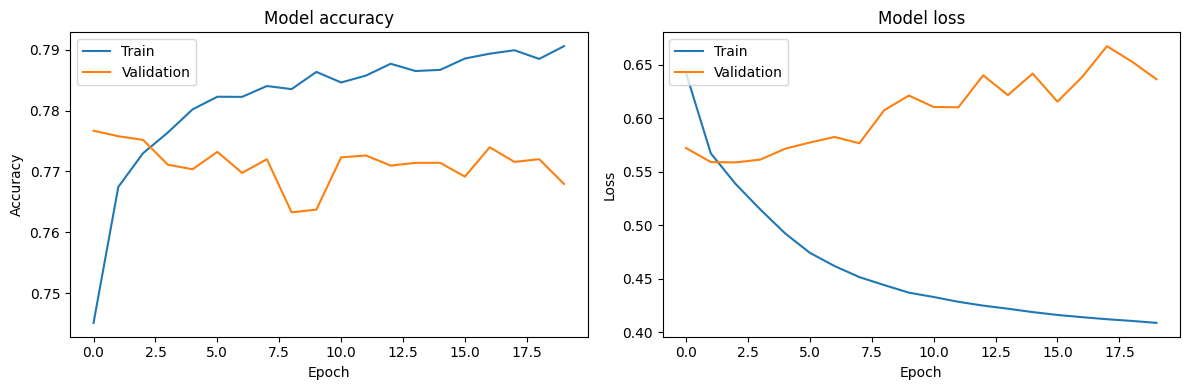

In [23]:
# Get predictions
y_pred = model.predict(X_test, batch_size=10)
y_pred_classes = y_pred.argmax(axis=1)

# Convert y_test from categorical back to integer
y_test_integers = [np.argmax(label) for label in y_test_cat]

# Print classification report
reverse_label_mapping = {idx: label for label, idx in label_mapping.items()}
target_names = [reverse_label_mapping[idx] for idx in range(num_classes)]
print(classification_report(y_test_integers, y_pred_classes, target_names=target_names))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()